# Task 2 - Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
# Importing libraries:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_df = pd.read_csv("TATA_raw_data.csv")
raw_df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
raw_df.shape

(2035, 8)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [6]:
raw_df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
raw_df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
raw_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

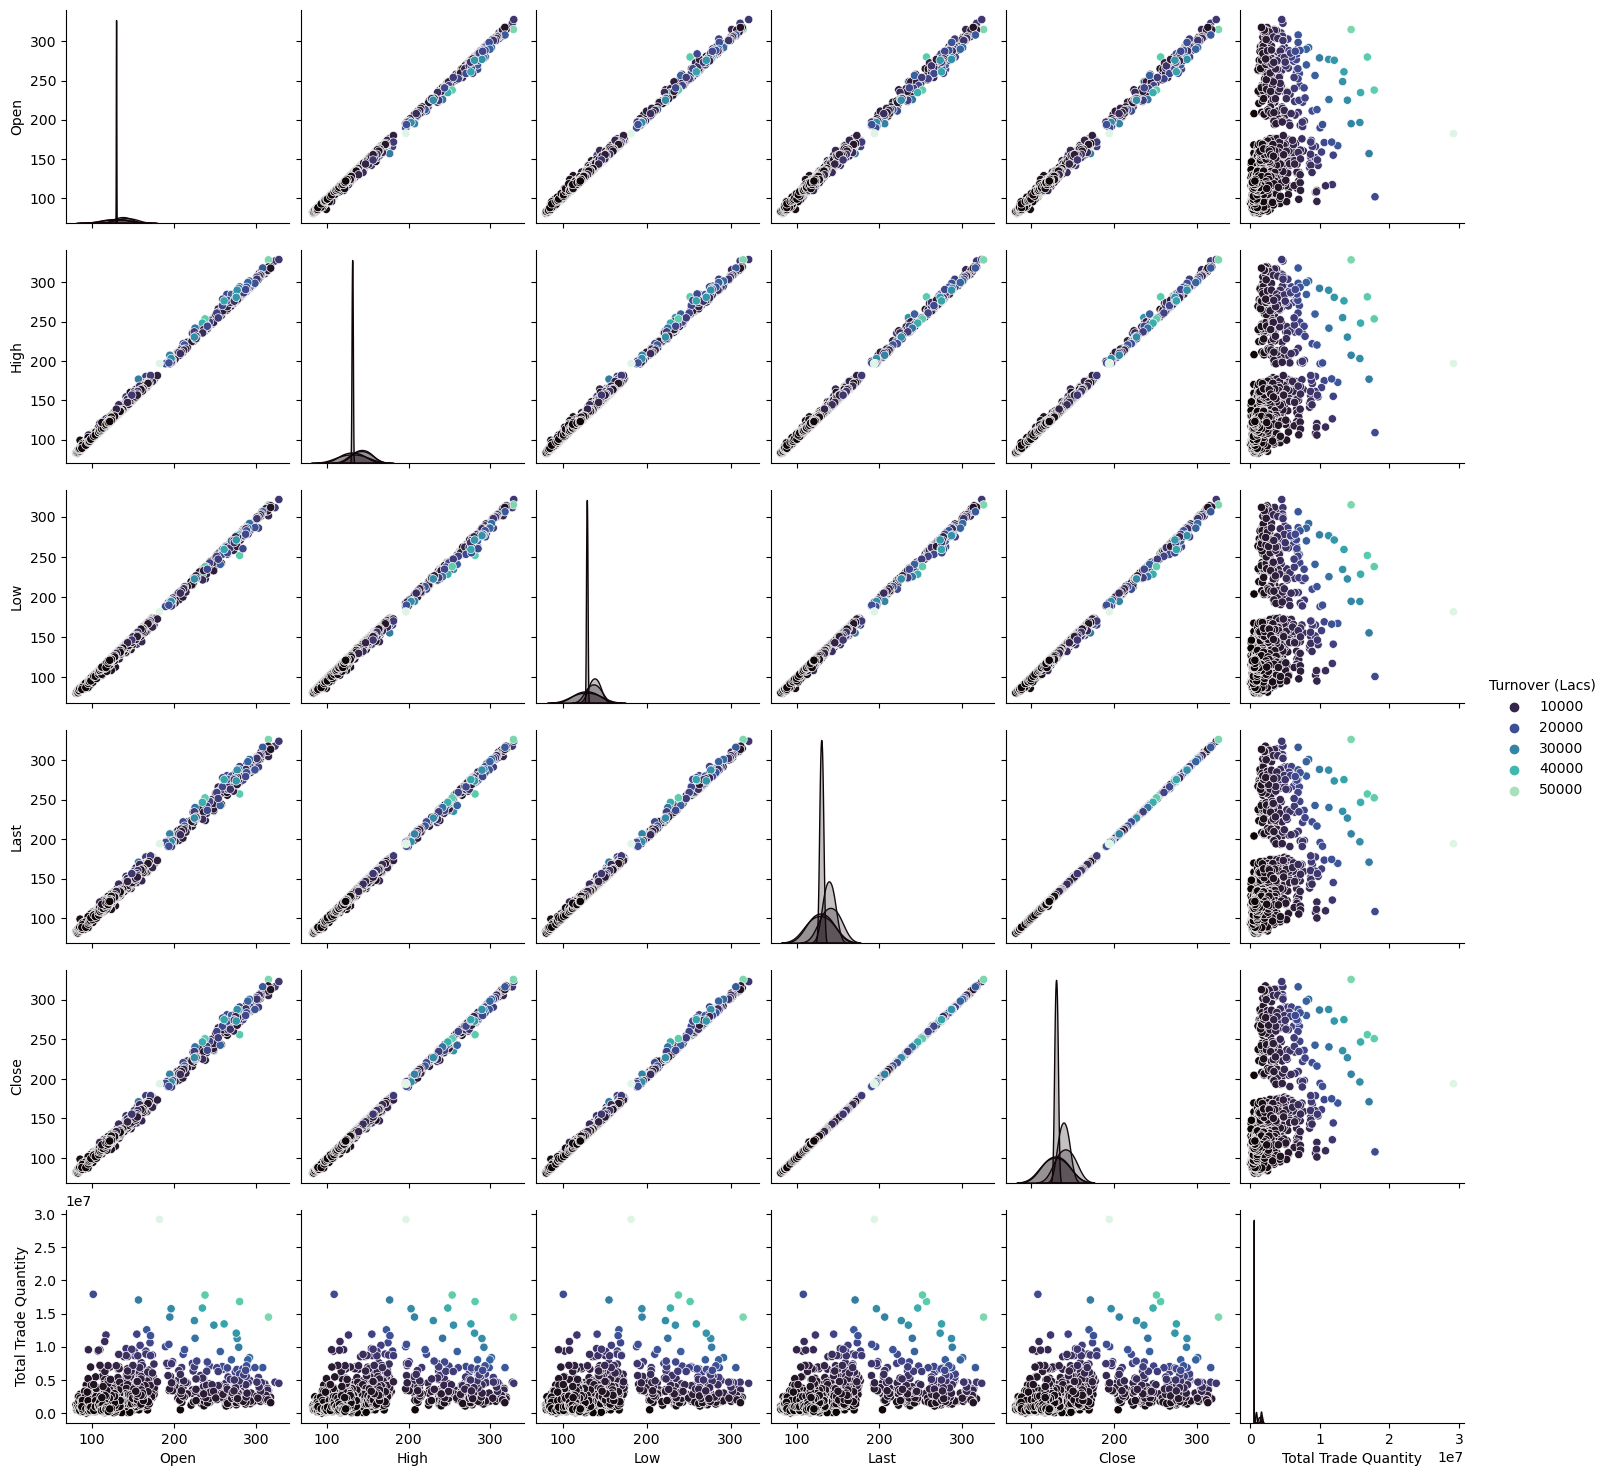

In [9]:
sns.pairplot(raw_df, hue='Turnover (Lacs)', palette="mako")
plt.show()

<Axes: >

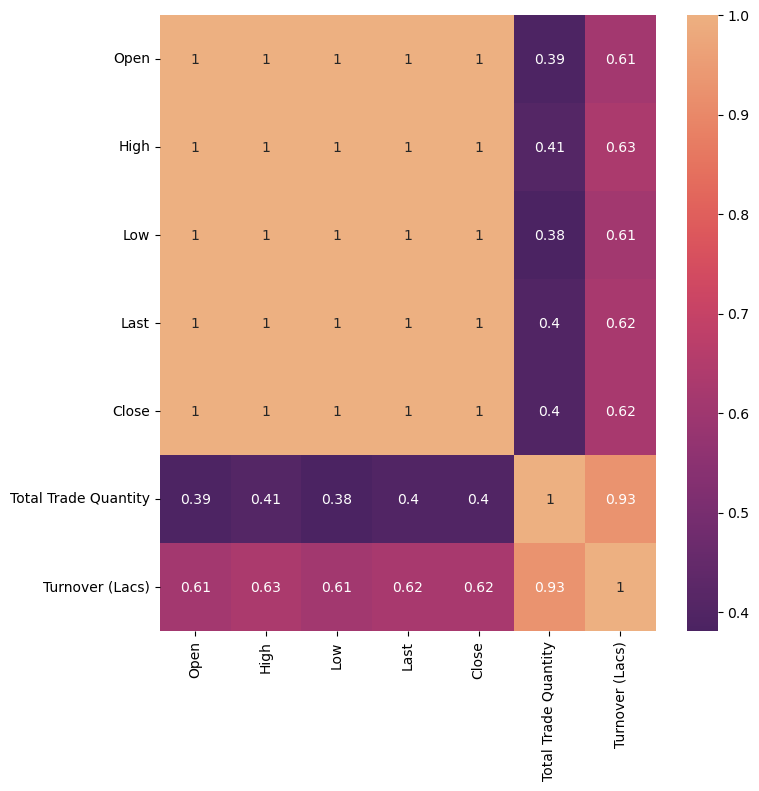

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(raw_df.corr(),annot=True,cmap='flare_r')

In [11]:
close_df=raw_df.reset_index()['Close']
close_df

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

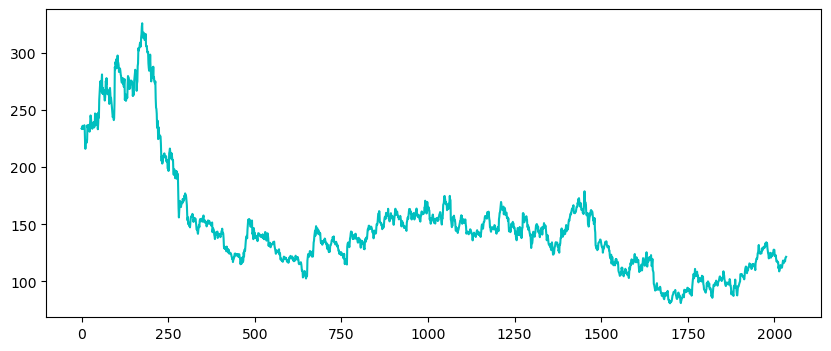

In [12]:
plt.figure(figsize=(10,4))
plt.plot(close_df, c= "c")
plt.show()

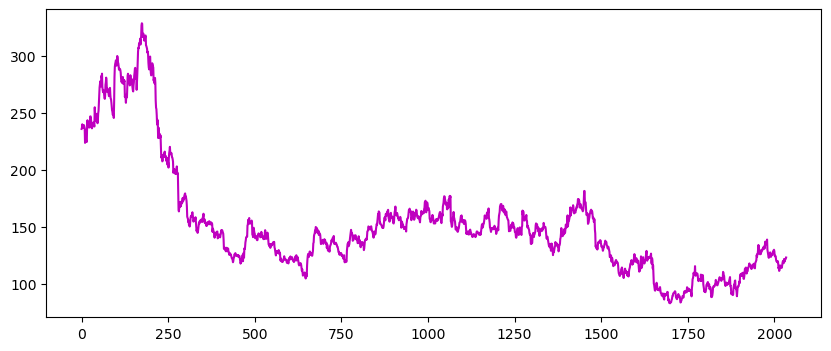

In [13]:
plt.figure(figsize=(10,4))

high_df=raw_df.reset_index()['High']
plt.plot(high_df, c="m")
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
high_df = scaler.fit_transform(np.array(high_df).reshape(-1,1))

In [15]:
high_df.shape

(2035, 1)

In [16]:
print(high_df)

[[0.62268754]
 [0.62614353]
 [0.6391543 ]
 ...
 [0.15917869]
 [0.15938199]
 [0.16344786]]


In [17]:
training_1 = int(len(high_df) * 0.75)
test_1 = len(high_df) - training_1
train_data, test_data = high_df[0:training_1,:], high_df[training_1:len(high_df),:1]

In [18]:
training_1,test_1

(1526, 509)

In [19]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [21]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [22]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [23]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

In [24]:
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 28s 495ms/step - loss: 0.0284 - val_loss: 0.0097
Epoch 2/100
23/23 [==============================] - 9s 388ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 3/100
23/23 [==============================] - 8s 370ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/100
23/23 [==============================] - 9s 384ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/100
23/23 [==============================] - 10s 430ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
23/23 [==============================] - 9s 407ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
23/23 [==============================] - 9s 399ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/100
23/23 [==============================] - 10s 441ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
23/23 [==============================] - 10s 436ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/100
23/23 [==============================] - 11s 465ms/step - loss: 9.7411e-04

Epoch 76/100
23/23 [==============================] - 10s 417ms/step - loss: 2.3967e-04 - val_loss: 2.6981e-04
Epoch 77/100
23/23 [==============================] - 10s 427ms/step - loss: 2.2490e-04 - val_loss: 1.8893e-04
Epoch 78/100
23/23 [==============================] - 10s 431ms/step - loss: 2.2623e-04 - val_loss: 2.2381e-04
Epoch 79/100
23/23 [==============================] - 10s 430ms/step - loss: 2.0412e-04 - val_loss: 1.8218e-04
Epoch 80/100
23/23 [==============================] - 9s 400ms/step - loss: 2.0906e-04 - val_loss: 2.3760e-04
Epoch 81/100
23/23 [==============================] - 10s 459ms/step - loss: 2.0437e-04 - val_loss: 2.3982e-04
Epoch 82/100
23/23 [==============================] - 9s 409ms/step - loss: 2.6549e-04 - val_loss: 2.1133e-04
Epoch 83/100
23/23 [==============================] - 10s 452ms/step - loss: 1.9774e-04 - val_loss: 2.0422e-04
Epoch 84/100
23/23 [==============================] - 10s 421ms/step - loss: 2.6249e-04 - val_loss: 1.9323e-04
Epo

In [28]:
train_pre = model.predict(x_train)
test_pre = model.predict(x_test)

In [29]:
train_pre = scaler.inverse_transform(train_pre)
test_pre = scaler.inverse_transform(test_pre)

In [30]:
math.sqrt(mean_squared_error(y_train, train_pre))

167.23927756356625

In [31]:
math.sqrt(mean_squared_error(y_test, test_pre))

108.1590690863803

In [32]:
back_num = 100
trainPredictPlot = np.empty_like(high_df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[back_num:len(train_pre) + back_num, :] = train_pre

testPredictPlot = np.empty_like(high_df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_pre) + (back_num * 2)+1:len(high_df) - 1, :] = test_pre

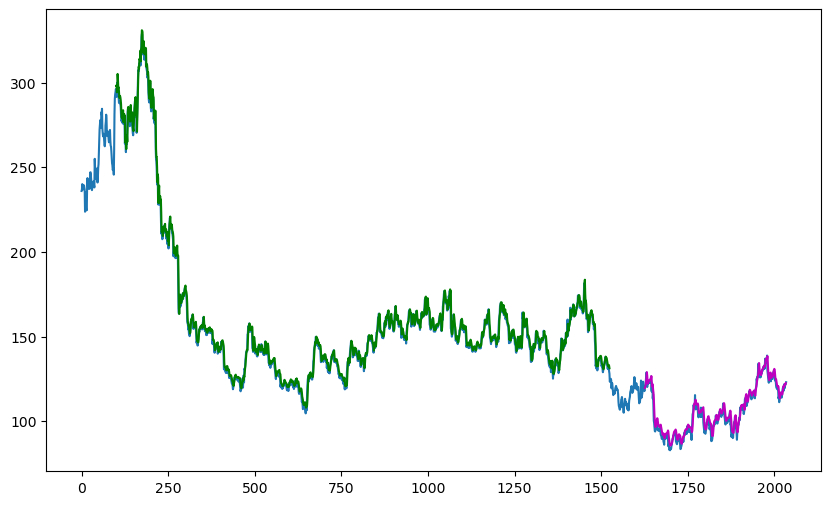

Blue indicates the Predicted Data
Green indicates the Complete Data
Magenta indicates the Train Data


In [33]:
plt.figure(figsize=(10,6))

plt.plot(scaler.inverse_transform(high_df))
plt.plot(trainPredictPlot,color='g')
plt.plot(testPredictPlot,color='m')
plt.show()

print("Blue indicates the Predicted Data")
print("Green indicates the Complete Data")
print("Magenta indicates the Train Data")

In [34]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [35]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [36]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16652416]
101
1 day input [0.13254727 0.13397032 0.13356373 0.13498679 0.14108559 0.13498679
 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778  0.15003049
 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546 0.19129904
 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727  0.17483228
 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892 0.18987599
 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665
 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754
 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372
 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426 0.16853019
 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839
 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654
 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037
 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811
 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385
 0.12807481 0.12624517 0.13051433

9 day output [[0.19388233]]
10 day input [0.14515145 0.1467778  0.15003049 0.15368977 0.17198618 0.16548079
 0.17625534 0.17564546 0.19129904 0.20817239 0.20309006 0.18479366
 0.17930474 0.1896727  0.17483228 0.17849156 0.17645863 0.18540354
 0.18377719 0.19190892 0.18987599 0.19028258 0.19394186 0.20004066
 0.19638138 0.19495832 0.20349665 0.19597479 0.21162838 0.22036999
 0.20979874 0.21528766 0.21589754 0.21610083 0.22748526 0.19150234
 0.1833706  0.17340923 0.16751372 0.1622281  0.17056312 0.17462899
 0.17930474 0.18174426 0.16853019 0.16548079 0.1742224  0.1713763
 0.17300264 0.17157959 0.17767839 0.18459036 0.18702988 0.18987599
 0.19109575 0.18581012 0.17015654 0.16751372 0.16974995 0.16609067
 0.15531612 0.15003049 0.15064037 0.14860744 0.14596463 0.15043708
 0.14413499 0.12441553 0.12827811 0.11547062 0.12034966 0.13478349
 0.13498679 0.12868469 0.13295385 0.12807481 0.12624517 0.13051433
 0.13905265 0.14718439 0.15104696 0.14515145 0.14311852 0.15816223
 0.15328319 0.14921732

17 day output [[0.21528693]]
18 day input [0.19129904 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727
 0.17483228 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892
 0.18987599 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832
 0.20349665 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766
 0.21589754 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923
 0.16751372 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426
 0.16853019 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959
 0.17767839 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012
 0.17015654 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049
 0.15064037 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553
 0.12827811 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469
 0.13295385 0.12807481 0.12624517 0.13051433 0.13905265 0.14718439
 0.15104696 0.14515145 0.14311852 0.15816223 0.15328319 0.14921732
 0.15531612 0.15917869 0.15938199 0.16344786 0.16652416 0.16966964
 0.17287272 0.1760506

25 day output [[0.23519216]]
26 day input [0.17645863 0.18540354 0.18377719 0.19190892 0.18987599 0.19028258
 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665 0.19597479
 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754 0.21610083
 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372 0.1622281
 0.17056312 0.17462899 0.17930474 0.18174426 0.16853019 0.16548079
 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839 0.18459036
 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654 0.16751372
 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037 0.14860744
 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811 0.11547062
 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385 0.12807481
 0.12624517 0.13051433 0.13905265 0.14718439 0.15104696 0.14515145
 0.14311852 0.15816223 0.15328319 0.14921732 0.15531612 0.15917869
 0.15938199 0.16344786 0.16652416 0.16966964 0.17287272 0.17605062
 0.17917766 0.18224333 0.18524382 0.18818022 0.19105743 0.19388233
 0.1966624  0.1994044

In [37]:
new = np.arange(1,101)
new_pre = np.arange(101,129)


In [38]:
new.shape

(100,)

In [39]:
new_pre.shape

(28,)

In [40]:
output = high_df.tolist()
output.extend(lst_output)

len(high_df)

2035

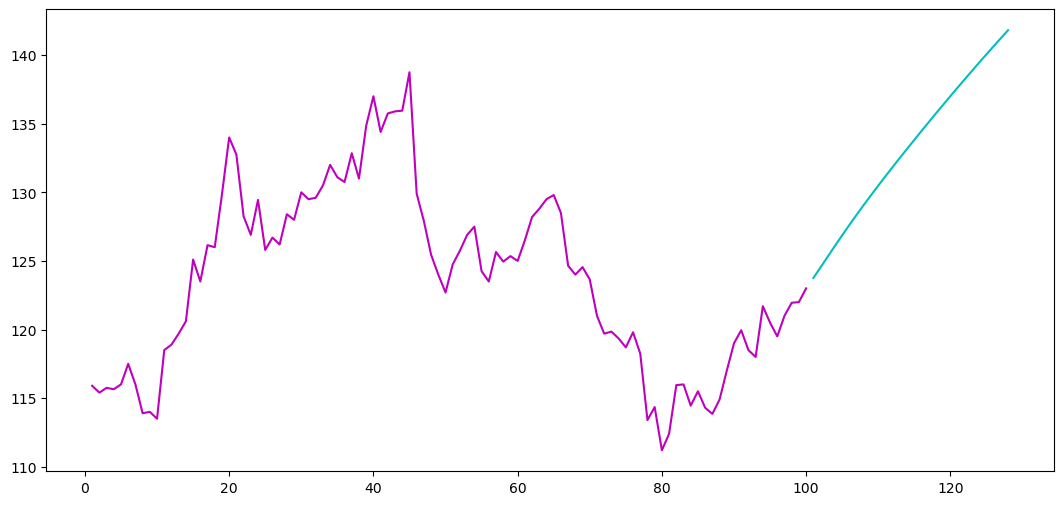

In [41]:
plt.figure(figsize=(13,6))

plt.plot(new, scaler.inverse_transform(high_df[1935:]),color='m')
plt.plot(new_pre, scaler.inverse_transform(lst_output),color='c')

plt.show()

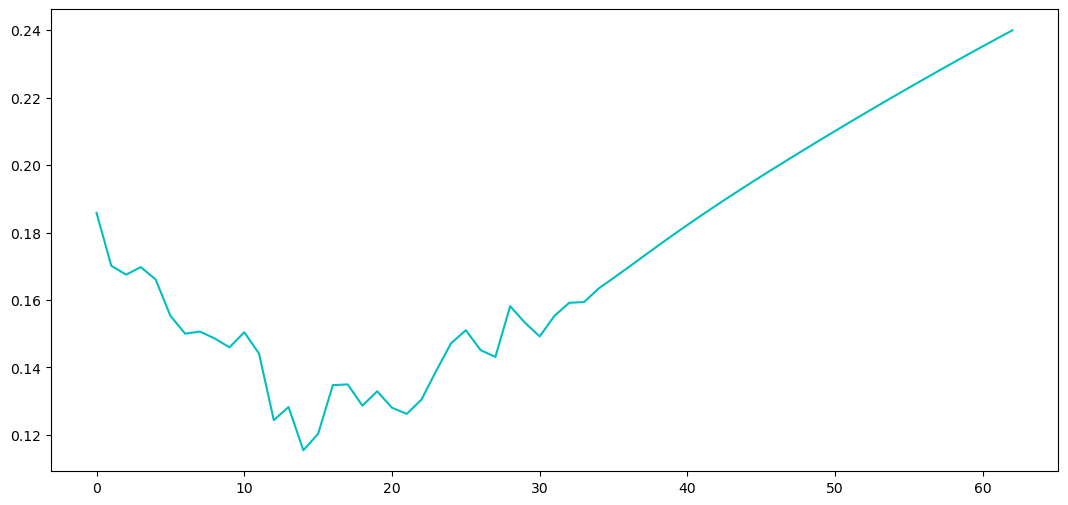

In [42]:
plt.figure(figsize=(13,6))

output=high_df.tolist()
output.extend(lst_output)
plt.plot(output[2000:],color='c')
plt.show()

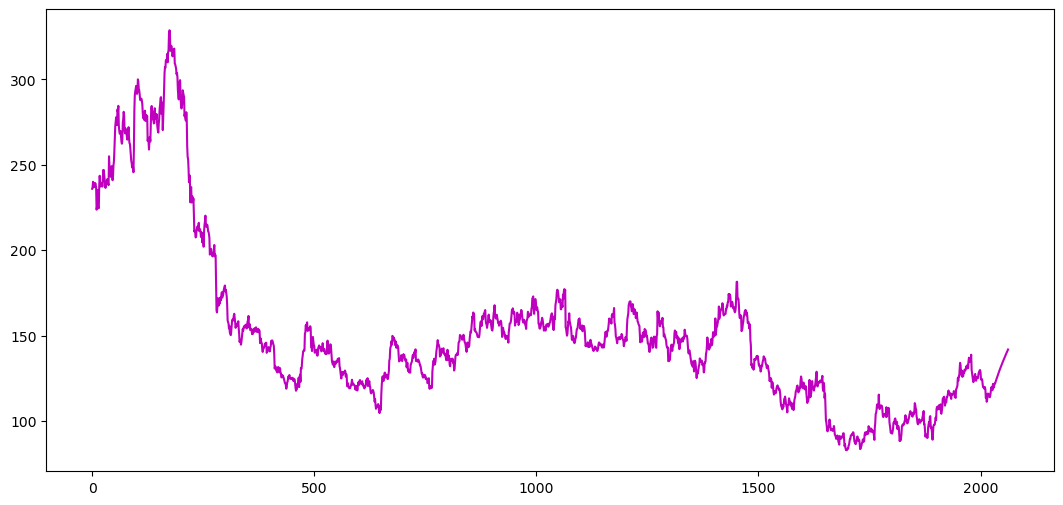

In [43]:
plt.figure(figsize=(13,6))

output=scaler.inverse_transform(output).tolist()
plt.plot(output,color='m')

plt.show()